In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np

from trustee import ClassificationTrustee

In [2]:
attacker_ips = {
    '169.231.210.93',
    '169.231.28.232',
    '169.231.123.195',
    '169.231.172.165',
    '169.231.11.193',
    '169.231.8.190',
    '169.231.10.199',
}

In [3]:
campus_dataset = pd.read_csv('campus_cicfeatures_1.csv')
campus_dataset['Class'] = 0
campus_dataset.loc[campus_dataset['Src IP'].isin(attacker_ips), 'Class'] = 1

print(len(campus_dataset))
ttl_data = pd.read_csv('campus_ttl_1.csv')
campus_dataset = campus_dataset.merge(ttl_data, on="Flow ID", how='left')
len(campus_dataset)
campus_dataset.to_csv('campus_dataset.csv')

6681


In [4]:
campus_dataset = campus_dataset.drop([
    'Flow ID',
    'Src IP',
    'Dst IP',
    'Timestamp', 
    'Protocol',    # always tcp
    'Label',       # empty
], axis=1)

In [5]:
azure_dataset = pd.read_csv('azure_cicfeatures_1.csv')
azure_dataset['Class'] = 0
azure_dataset.loc[azure_dataset['Src IP'].isin(attacker_ips), 'Class'] = 1
ttl_df_azure = pd.read_csv('azure_ttl_1.csv')
azure_dataset = azure_dataset.merge(ttl_df_azure, on="Flow ID", how='left')
azure_dataset = azure_dataset.replace([np.inf, -np.inf], np.nan)
azure_dataset = azure_dataset.dropna(axis=0)
azure_dataset.to_csv('azure_dataset.csv')

In [6]:
attacker_ips = {
    '157.245.108.149',
    '34.214.149.122',
}

multicloud_dataset = pd.read_csv('multicloud_cicfeatures_1.csv')
multicloud_dataset['Class'] = 0
multicloud_dataset.loc[multicloud_dataset['Src IP'].isin(attacker_ips), 'Class'] = 1
ttl_df_multicloud = pd.read_csv('multicloud_ttl_1.csv')
multicloud_dataset = multicloud_dataset.merge(ttl_df_multicloud, on="Flow ID", how='left')
multicloud_dataset = multicloud_dataset.replace([np.inf, -np.inf], np.nan)
multicloud_dataset = multicloud_dataset.dropna(axis=0)
multicloud_dataset.to_csv('multicloud_dataset.csv')

In [7]:
# CIC-IDS-2018
dpath = "~/data/ids2018/Wednesday-14-02-2018_TrafficForML_CICFlowMeter.csv"
cic_dataset = pd.read_csv(dpath)

In [8]:
features_rename = {
    'Fwd Pkts/b Avg': 'Fwd Packet/Bulk Avg',
    'Flow Byts/s': 'Flow Bytes/s',
    'Tot Fwd Pkts': 'Total Fwd Packet',
    'Pkt Size Avg': 'Average Packet Size',
    'Fwd Byts/b Avg': 'Fwd Bytes/Bulk Avg',
    'Fwd Pkts/s': 'Fwd Packets/s',
    'Bwd Pkt Len Max': 'Bwd Packet Length Max',
    'Fwd Header Len': 'Fwd Header Length',
    'Flow Pkts/s': 'Flow Packets/s',
    'Fwd Pkt Len Min': 'Fwd Packet Length Min',
    'RST Flag Cnt': 'RST Flag Count',
    'ECE Flag Cnt': 'ECE Flag Count',
    'Subflow Fwd Byts': 'Subflow Fwd Bytes',
    'Subflow Bwd Pkts': 'Subflow Bwd Packets',
    'TotLen Bwd Pkts': 'Total Length of Bwd Packet',
    'Bwd Header Len': 'Bwd Header Length',
    'Pkt Len Std': 'Packet Length Std',
    'Subflow Bwd Byts': 'Subflow Bwd Bytes',
    'Pkt Len Min': 'Packet Length Min',
    'TotLen Fwd Pkts': 'Total Length of Fwd Packet',
    'Pkt Len Var': 'Packet Length Variance',
    'Subflow Fwd Pkts': 'Subflow Fwd Packets',
    'Fwd Blk Rate Avg': 'Fwd Bulk Rate Avg',
    'Bwd Pkt Len Mean': 'Bwd Packet Length Mean',
    'Bwd Seg Size Avg': 'Bwd Segment Size Avg',
    'Bwd Pkts/s': 'Bwd Packets/s',
    'URG Flag Cnt': 'URG Flag Count',
    'FIN Flag Cnt': 'FIN Flag Count',
    'ACK Flag Cnt': 'ACK Flag Count',
    'Init Bwd Win Byts': 'Bwd Init Win Bytes',
    'Fwd Seg Size Avg': 'Fwd Segment Size Avg',
    'Init Fwd Win Byts': 'FWD Init Win Bytes',
    'Fwd IAT Tot': 'Fwd IAT Total',
    'Bwd Pkt Len Std': 'Bwd Packet Length Std',
    'Bwd Byts/b Avg': 'Bwd Bytes/Bulk Avg',
    'Fwd Pkt Len Std': 'Fwd Packet Length Std',
    'Pkt Len Max': 'Packet Length Max',
    'Bwd Pkt Len Min': 'Bwd Packet Length Min',
    'Tot Bwd Pkts': 'Total Bwd packets',
    'Fwd Pkt Len Max': 'Fwd Packet Length Max',
    'Bwd Pkts/b Avg': 'Bwd Packet/Bulk Avg',
    'Fwd Pkt Len Mean': 'Fwd Packet Length Mean',
    'PSH Flag Cnt': 'PSH Flag Count',
    'Bwd IAT Tot': 'Bwd IAT Total',
    'SYN Flag Cnt': 'SYN Flag Count',
    'Pkt Len Mean': 'Packet Length Mean',
    'Bwd Blk Rate Avg': 'Bwd Bulk Rate Avg',
    'CWE Flag Count': 'CWR Flag Count',
}

In [9]:
cic_dataset = cic_dataset.rename({x: features_rename.get(x.strip(), x.strip()) for x in cic_dataset.columns}, axis=1)
cic_dataset['Src Port'] = np.random.randint(20000, 40000, cic_dataset.shape[0])

# Here's important point: we couldn't extract true TTL from CIC-IDS-2018
# So we have to synthesize some data here
# And this is a good confirmation that TTL is a main feature used by models

# This gives you around 0.6 F1 score
cic_dataset['TTL'] = np.random.randint(60, 64, cic_dataset.shape[0])

# These settings give you 0.1 total F1 score
cic_dataset['TTL'] = 63
cic_dataset.loc[cic_dataset['Label'] != 'Benign', 'TTL'] = 60

# These settings give you 1.0 total F1 score!
cic_dataset['TTL'] = 60
cic_dataset.loc[cic_dataset['Label'] != 'Benign', 'TTL'] = 63


cic_dataset['Class'] = 0
cic_dataset.loc[cic_dataset['Label'] != 'Benign', 'Class'] = 1

cic_dataset = cic_dataset.replace([np.inf, -np.inf], np.nan)
cic_dataset = cic_dataset.dropna(axis=0)

In [10]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

Train on campus dataset, check on Azure, multicloud, and CIC-18

In [11]:
target_variable = 'Class'
features = list(set(campus_dataset.columns) - {target_variable})
x_train = campus_dataset[features]
y_train = campus_dataset[target_variable]
x_test = azure_dataset[features]
y_test = azure_dataset[target_variable]
x_test_2 = multicloud_dataset[features]
y_test_2 = multicloud_dataset[target_variable]
x_test_3 = cic_dataset[features]
y_test_3 = cic_dataset[target_variable]

In [12]:
from sklearn.preprocessing import StandardScaler
x_train_scaler = StandardScaler()
x_test_scaler = StandardScaler()
x_test_2_scaler = StandardScaler()
x_test_3_scaler = StandardScaler()

x_train = pd.DataFrame(x_train_scaler.fit_transform(x_train), columns = x_train.columns)
x_test = pd.DataFrame(x_test_scaler.fit_transform(x_test), columns = x_test.columns)
x_test_2 = pd.DataFrame(x_test_2_scaler.fit_transform(x_test_2), columns = x_test_2.columns)
x_test_3 = pd.DataFrame(x_test_3_scaler.fit_transform(x_test_3), columns = x_test_3.columns)

In [13]:
classifiers = [
    MLPClassifier(),
    GradientBoostingClassifier(),
    RandomForestClassifier(),
]

In [14]:
for clf in classifiers:
    print(clf)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_train)
    print("campus dataset training accuracy: ")
    print(metrics.classification_report(y_train, y_pred))

    print("Azure dataset test accuracy: ")
    y_pred = clf.predict(x_test)
    print(metrics.classification_report(y_test, y_pred))
    print(metrics.confusion_matrix(y_test, y_pred))
    
    print("Multicloud dataset test accuracy: ")
    y_pred = clf.predict(x_test_2)
    print(metrics.classification_report(y_test_2, y_pred))
    print(metrics.confusion_matrix(y_test_2, y_pred))
    
    print("CIC-IDS-2018 dataset test accuracy: ")
    y_pred = clf.predict(x_test_3)
    print(metrics.classification_report(y_test_3, y_pred))
    print(metrics.confusion_matrix(y_test_3, y_pred))
    print('#' * 10 + '\n')

MLPClassifier()
campus dataset training accuracy: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5614
           1       1.00      1.00      1.00      1067

    accuracy                           1.00      6681
   macro avg       1.00      1.00      1.00      6681
weighted avg       1.00      1.00      1.00      6681

Azure dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.62      0.51      0.56       528
           1       0.35      0.46      0.40       307

    accuracy                           0.49       835
   macro avg       0.48      0.48      0.48       835
weighted avg       0.52      0.49      0.50       835

[[267 261]
 [166 141]]
Multicloud dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.97      0.55      0.70      5547
           1       0.18      0.85      0.29       638

    accuracy                           0.58

Let's explore the reasons of this performance

campus dataset training accuracy: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5614
           1       1.00      1.00      1.00      1067

    accuracy                           1.00      6681
   macro avg       1.00      1.00      1.00      6681
weighted avg       1.00      1.00      1.00      6681

Azure dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.48      0.53      0.50       528
           1       0.00      0.00      0.00       307

    accuracy                           0.34       835
   macro avg       0.24      0.27      0.25       835
weighted avg       0.30      0.34      0.32       835

[[281 247]
 [307   0]]
Multicloud dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.86      0.73      0.79      5547
           1       0.00      0.00      0.00       638

    accuracy                           0.65      6185
   ma

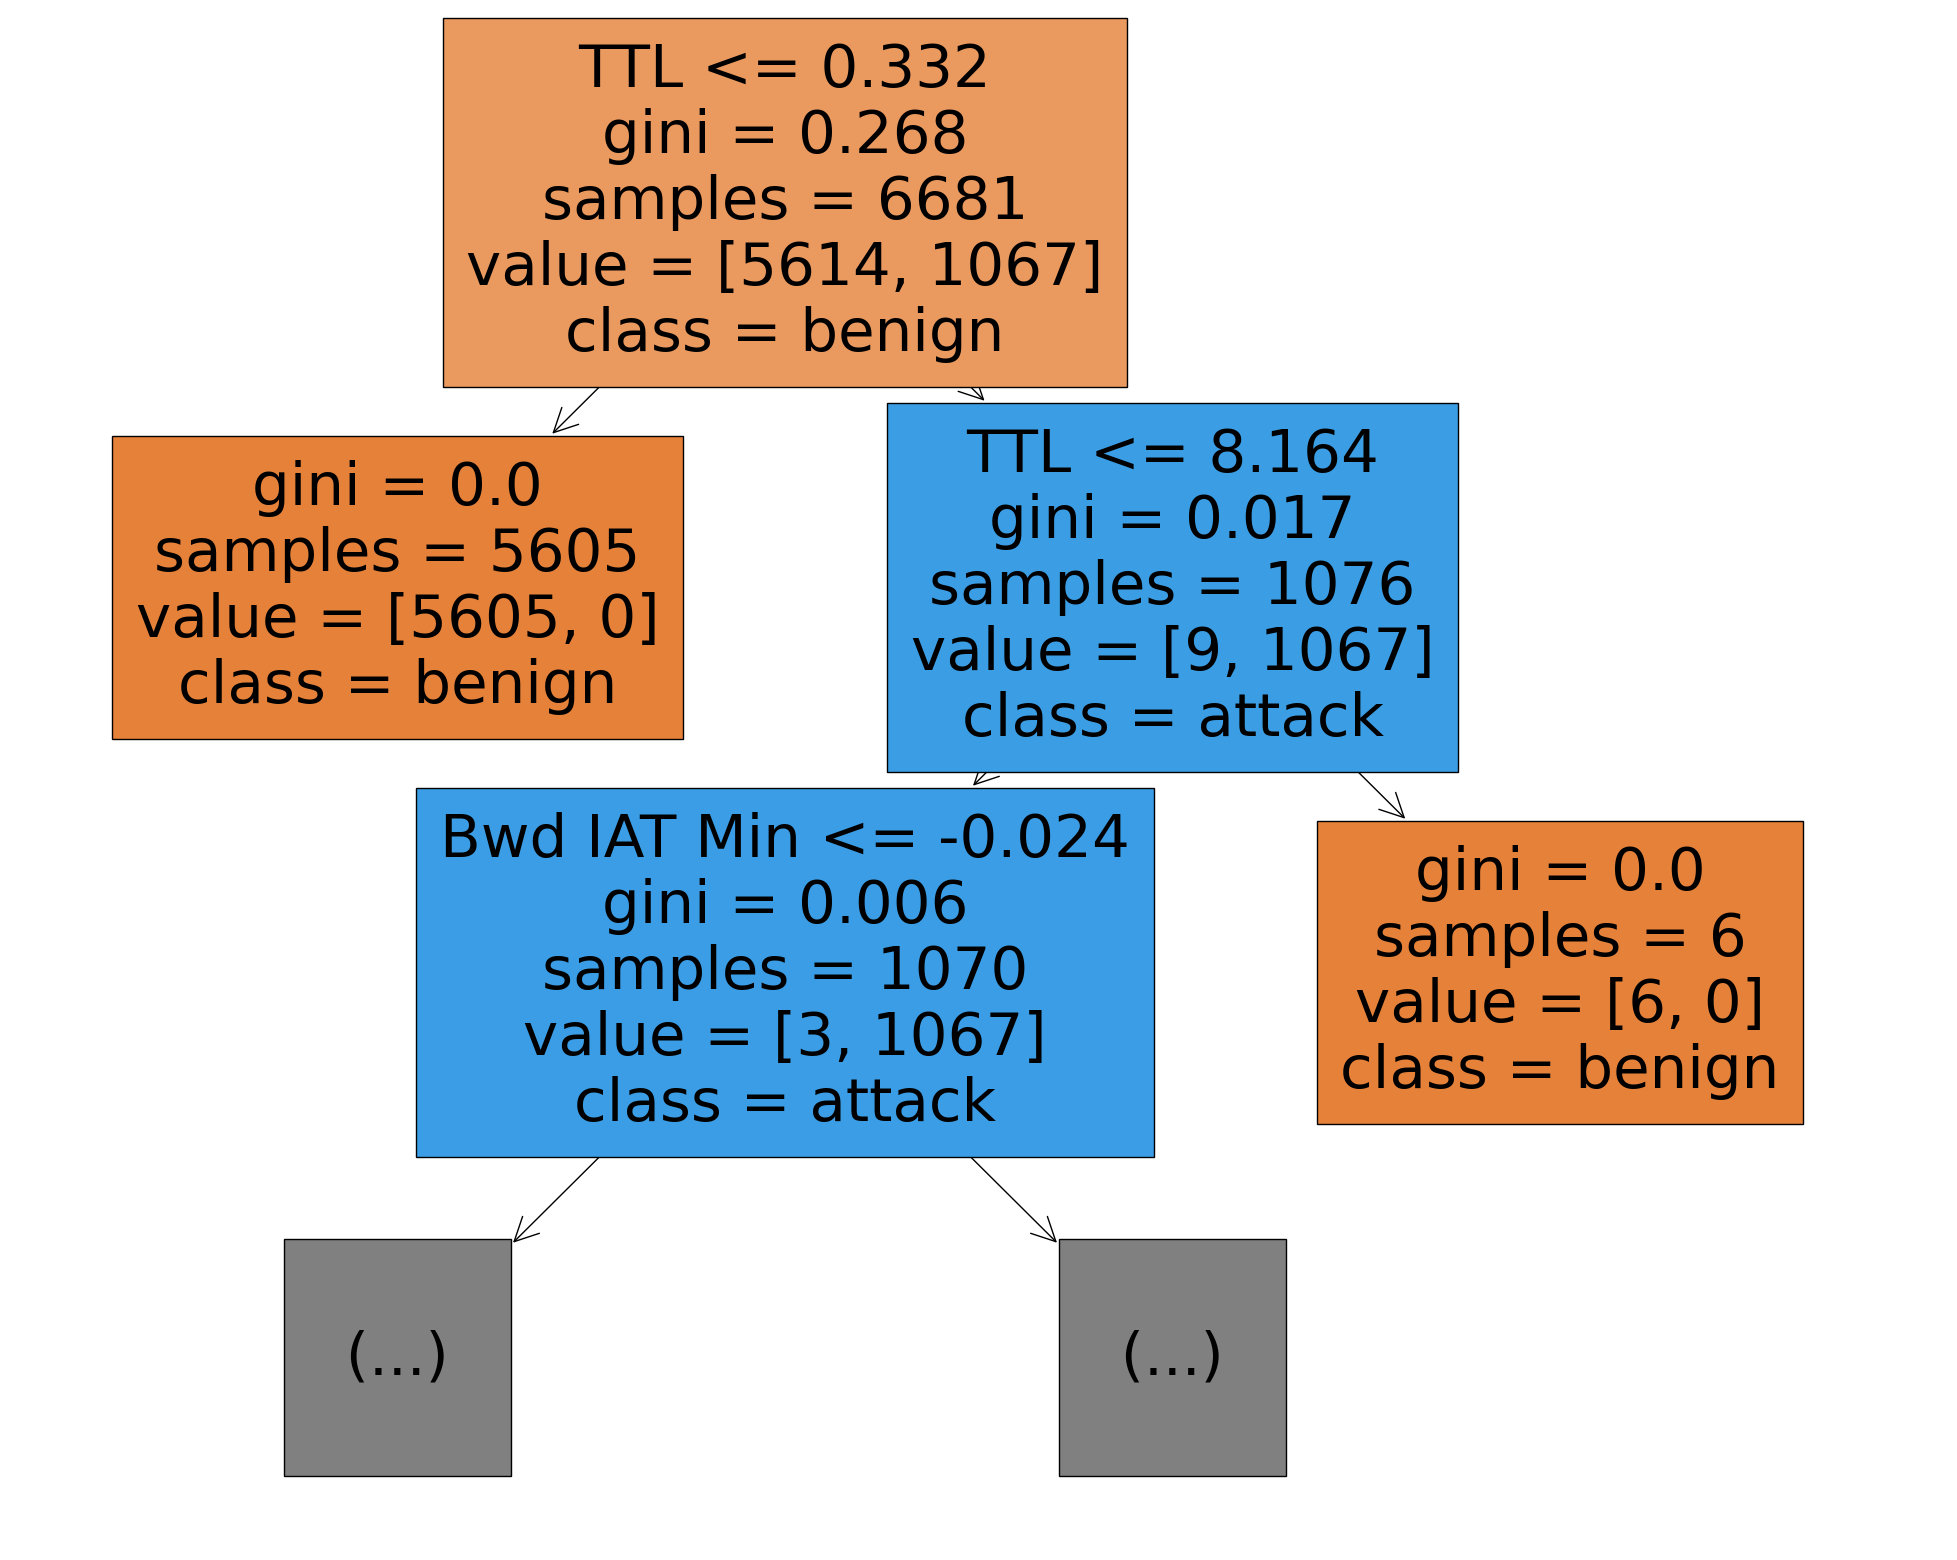

In [15]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)

y_pred = clf.predict(x_train)
print("campus dataset training accuracy: ")
print(metrics.classification_report(y_train, y_pred))

y_pred = clf.predict(x_test)
print("Azure dataset test accuracy: ")
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

y_pred = clf.predict(x_test_2)
print("Multicloud dataset test accuracy: ")
print(metrics.classification_report(y_test_2, y_pred))
print(metrics.confusion_matrix(y_test_2, y_pred))

y_pred = clf.predict(x_test_3)
print("CIC-IDS-2018 dataset test accuracy: ")
print(metrics.classification_report(y_test_3, y_pred))
print(metrics.confusion_matrix(y_test_3, y_pred))

fig = plt.figure(figsize=(25,20))
_ = plot_tree(clf, feature_names=x_train.columns, class_names=['benign', 'attack'], filled=True, max_depth=2)

The answer is a shortcut in the dataset - usage of TTL as a feature.  
Random forests choose features randomly and therefore often remove TTL from the list and doesn't overfit to it.  

Anyway, TTL is a plain shortcut, let's remove it.

## Out of curiosity - dropping or noising the features
Use information from the future - we know that TTL and Init Win Bytes are or would be shortcuts, so let's add some noise there or drop them and check performance.

In [16]:
target_variable = 'Class'
features = list(set(campus_dataset.columns) - {target_variable})
x_train = campus_dataset[features].copy()
y_train = campus_dataset[target_variable]
x_test = azure_dataset[features]
y_test = azure_dataset[target_variable]
x_test_2 = multicloud_dataset[features]
y_test_2 = multicloud_dataset[target_variable]
x_test_3 = cic_dataset[features]
y_test_3 = cic_dataset[target_variable]

In [17]:
x_train.loc[:, 'TTL'] += np.random.randint(-1, 1, [len(x_train)])
x_train.loc[:, 'Bwd Init Win Bytes'] += np.random.randint(-5, 5, [len(x_train)])

In [18]:
x_train = pd.DataFrame(StandardScaler().fit_transform(x_train), columns = x_train.columns)
x_test = pd.DataFrame(StandardScaler().fit_transform(x_test), columns = x_test.columns)
x_test_2 = pd.DataFrame(StandardScaler().fit_transform(x_test_2), columns = x_test_2.columns)
x_test_3 = pd.DataFrame(StandardScaler().fit_transform(x_test_3), columns = x_test_3.columns)

In [19]:
classifiers = [
    MLPClassifier(),
    GradientBoostingClassifier(),
    RandomForestClassifier(),
]
for clf in classifiers:
    print(clf)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_train)
    print("campus dataset training accuracy: ")
    print(metrics.classification_report(y_train, y_pred))

    print("Azure dataset test accuracy: ")
    y_pred = clf.predict(x_test)
    print(metrics.classification_report(y_test, y_pred))
    print(metrics.confusion_matrix(y_test, y_pred))
    
    print("Multicloud dataset test accuracy: ")
    y_pred = clf.predict(x_test_2)
    print(metrics.classification_report(y_test_2, y_pred))
    print(metrics.confusion_matrix(y_test_2, y_pred))
    
    print("CIC-IDS-2018 dataset test accuracy: ")
    y_pred = clf.predict(x_test_3)
    print(metrics.classification_report(y_test_3, y_pred))
    print(metrics.confusion_matrix(y_test_3, y_pred))
    print('#' * 10 + '\n')

MLPClassifier()
campus dataset training accuracy: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5614
           1       1.00      1.00      1.00      1067

    accuracy                           1.00      6681
   macro avg       1.00      1.00      1.00      6681
weighted avg       1.00      1.00      1.00      6681

Azure dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.69      0.51      0.58       528
           1       0.42      0.62      0.50       307

    accuracy                           0.55       835
   macro avg       0.56      0.56      0.54       835
weighted avg       0.59      0.55      0.55       835

[[267 261]
 [118 189]]
Multicloud dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.97      0.55      0.70      5547
           1       0.18      0.85      0.29       638

    accuracy                           0.58

### Or let's just drop them

In [20]:
x_train = x_train.drop(['TTL', 'Bwd Init Win Bytes'], axis=1)
x_test = x_test.drop(['TTL', 'Bwd Init Win Bytes'], axis=1)
x_test_2 = x_test_2.drop(['TTL', 'Bwd Init Win Bytes'], axis=1)
x_test_3 = x_test_3.drop(['TTL', 'Bwd Init Win Bytes'], axis=1)

In [21]:
classifiers = [
    MLPClassifier(),
    GradientBoostingClassifier(),
    RandomForestClassifier(max_depth=4),
]
for clf in classifiers:
    print(clf)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_train)
    print("campus dataset training accuracy: ")
    print(metrics.classification_report(y_train, y_pred))

    print("Azure dataset test accuracy: ")
    y_pred = clf.predict(x_test)
    print(metrics.classification_report(y_test, y_pred))
    print(metrics.confusion_matrix(y_test, y_pred))
    
    print("Multicloud dataset test accuracy: ")
    y_pred = clf.predict(x_test_2)
    print(metrics.classification_report(y_test_2, y_pred))
    print(metrics.confusion_matrix(y_test_2, y_pred))
    
    print("CIC-IDS-2018 dataset test accuracy: ")
    y_pred = clf.predict(x_test_3)
    print(metrics.classification_report(y_test_3, y_pred))
    print(metrics.confusion_matrix(y_test_3, y_pred))
    print('#' * 10 + '\n')

MLPClassifier()
campus dataset training accuracy: 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5614
           1       0.99      0.79      0.88      1067

    accuracy                           0.96      6681
   macro avg       0.98      0.89      0.93      6681
weighted avg       0.97      0.96      0.96      6681

Azure dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       528
           1       1.00      0.92      0.96       307

    accuracy                           0.97       835
   macro avg       0.98      0.96      0.97       835
weighted avg       0.97      0.97      0.97       835

[[527   1]
 [ 25 282]]
Multicloud dataset test accuracy: 
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      5547
           1       0.64      0.98      0.78       638

    accuracy                           0.94

Training score of pruned DT: 1.0
Model explanation global fidelity report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       552
           1       0.99      1.00      0.99       283

    accuracy                           0.99       835
   macro avg       0.99      0.99      0.99       835
weighted avg       0.99      0.99      0.99       835

Model explanation score report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       528
           1       0.99      0.92      0.95       307

    accuracy                           0.97       835
   macro avg       0.97      0.96      0.96       835
weighted avg       0.97      0.97      0.96       835



/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


[Text(0.5, 0.75, 'Total Length of Fwd Packet <= -0.146\ngini = 0.223\nsamples = 2618\nvalue = [2283, 335]\nclass = benign'),
 Text(0.25, 0.25, 'gini = 0.096\nsamples = 2403\nvalue = [2281, 122]\nclass = benign'),
 Text(0.75, 0.25, 'gini = 0.018\nsamples = 215\nvalue = [2, 213]\nclass = attack')]

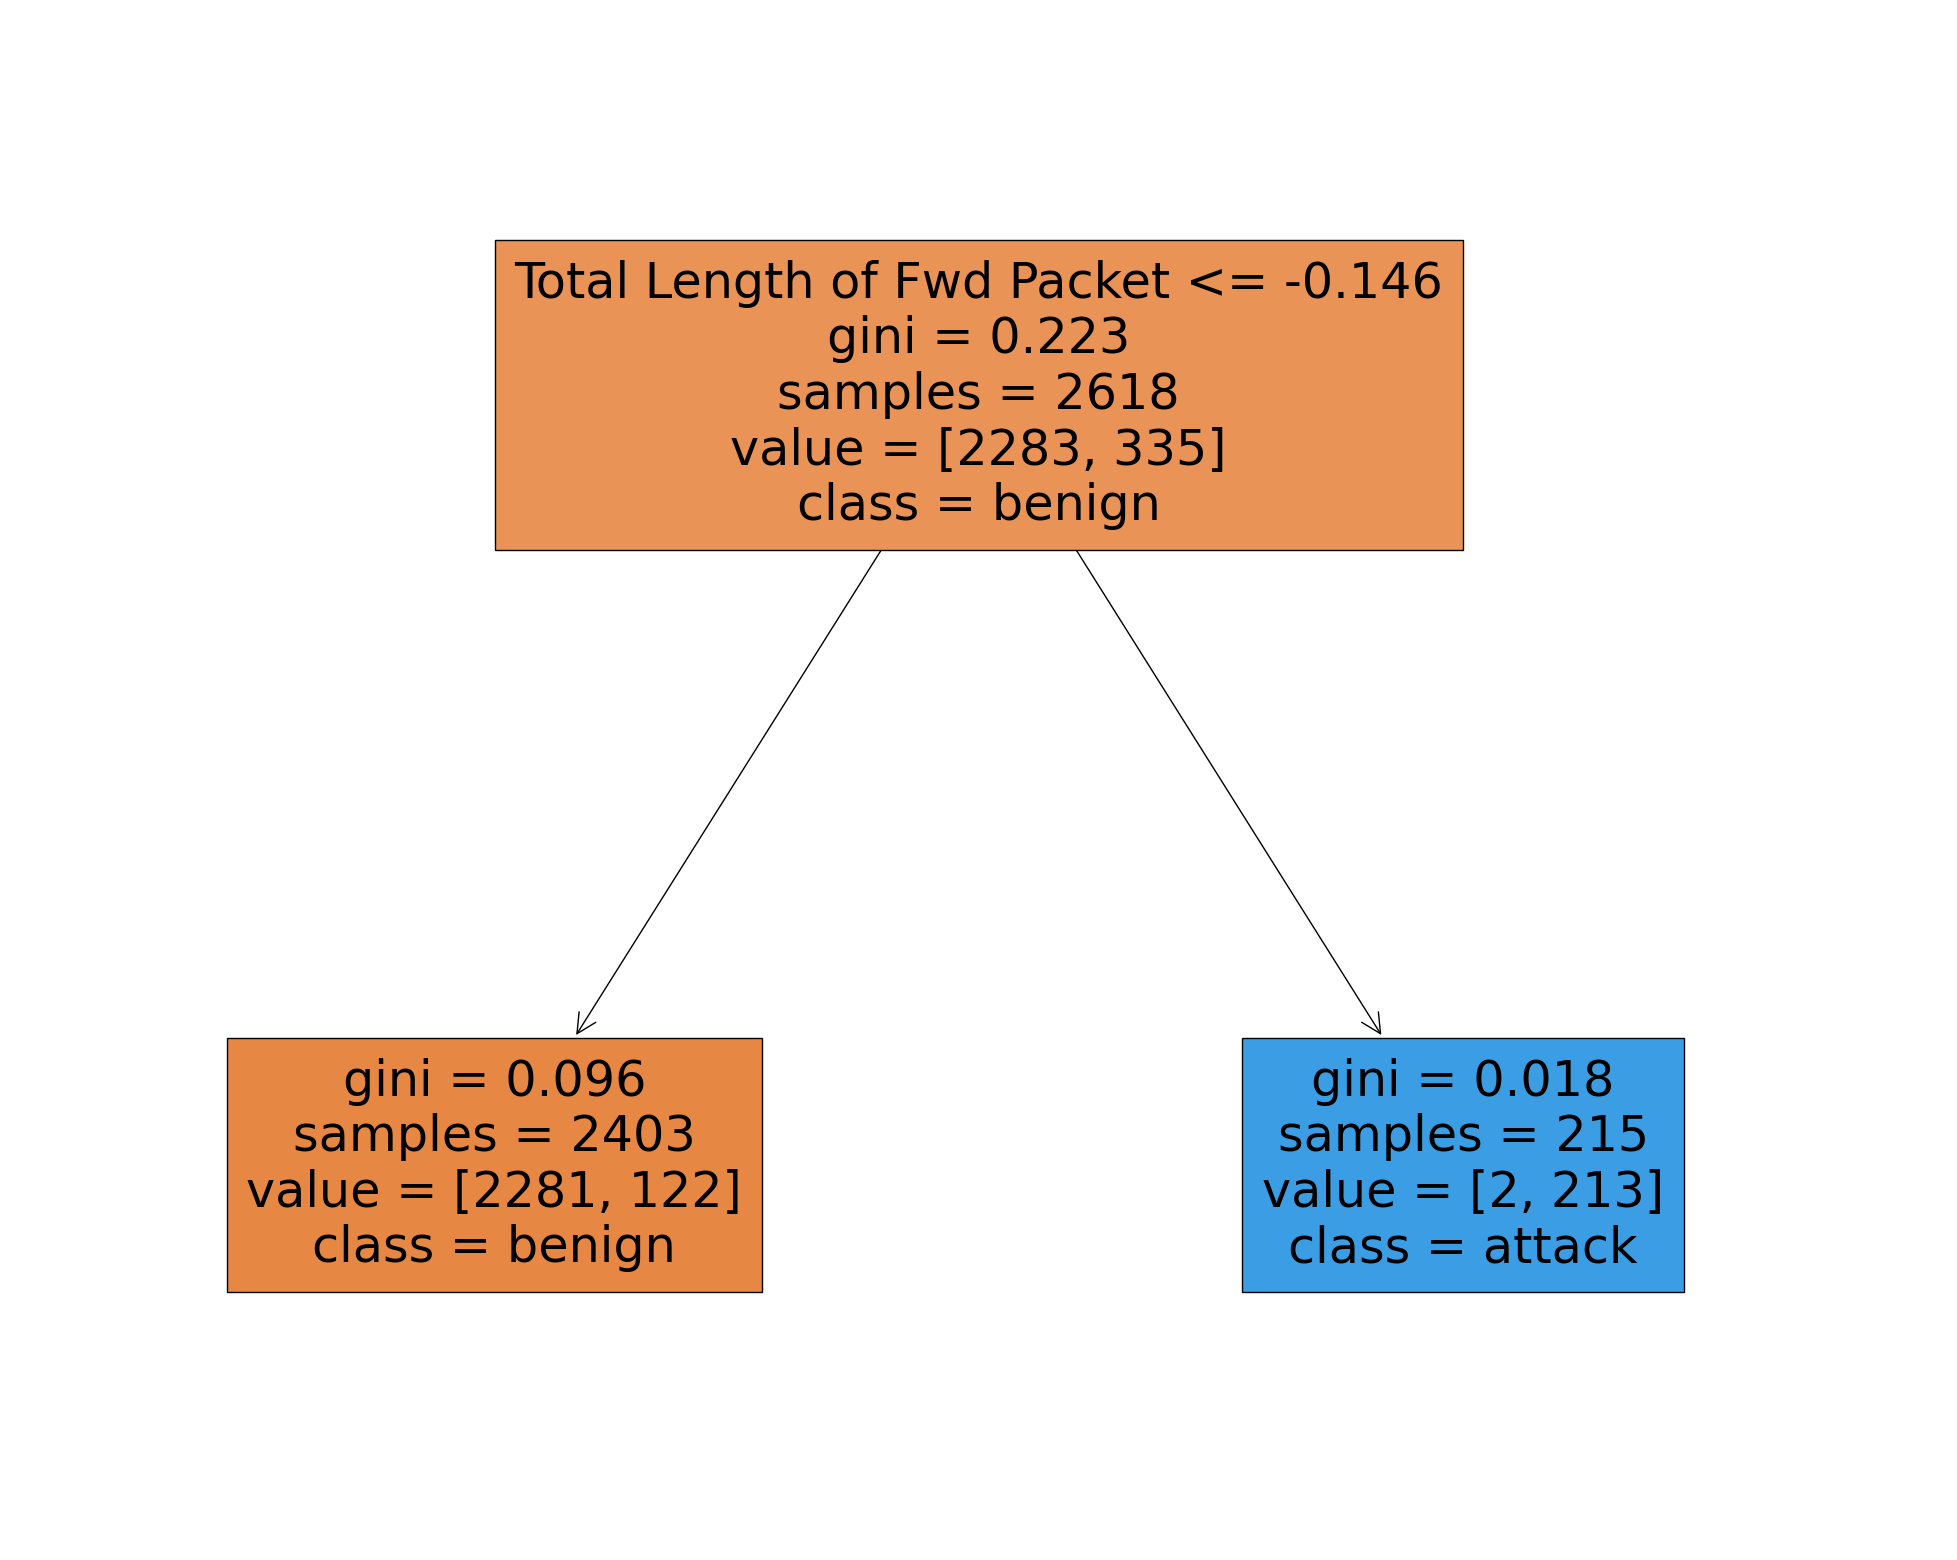

In [22]:
trustee = ClassificationTrustee(expert=classifiers[0])
trustee.fit(x_train, y_train, num_iter=10, num_stability_iter=3, samples_size=0.8)

_, dt, _, score = trustee.explain()
print(f"Training score of pruned DT: {score}")
dt_y_pred = dt.predict(x_test)

print("Model explanation global fidelity report:")
print(metrics.classification_report(classifiers[0].predict(x_test), dt_y_pred))
print("Model explanation score report:")
print(metrics.classification_report(y_test, dt_y_pred))

fig = plt.figure(figsize=(25,20))
plot_tree(dt, feature_names=x_train.columns, class_names=['benign', 'attack'], filled=True, max_depth=3)

### Checking SMOTE

In [23]:
import smote_variants as sv

In [24]:
target_variable = 'Class'
features = list(set(campus_dataset.columns) - {target_variable})
x_train = campus_dataset[features].copy()
y_train = campus_dataset[target_variable]
x_test = azure_dataset[features]
y_test = azure_dataset[target_variable]
x_test_2 = multicloud_dataset[features]
y_test_2 = multicloud_dataset[target_variable]
x_test_3 = cic_dataset[features]
y_test_3 = cic_dataset[target_variable]

In [25]:
from sklearn.preprocessing import StandardScaler

x_train = pd.DataFrame(StandardScaler().fit_transform(x_train), columns = x_train.columns)
x_test = pd.DataFrame(StandardScaler().fit_transform(x_test), columns = x_test.columns)
x_test_2 = pd.DataFrame(StandardScaler().fit_transform(x_test_2), columns = x_test_2.columns)
x_test_3 = pd.DataFrame(StandardScaler().fit_transform(x_test_3), columns = x_test_3.columns)

In [26]:
oversampler = sv.SMOTE()
X_samp, y_samp = oversampler.sample(x_train.to_numpy(), y_train.to_numpy())

classifiers = [
    MLPClassifier(),
    GradientBoostingClassifier(),
    RandomForestClassifier(max_depth=4),
]
for clf in classifiers:
    print(clf)
    clf.fit(X_samp, y_samp)
    y_pred = clf.predict(X_samp)
    print("campus dataset training accuracy: ")
    print(metrics.classification_report(y_samp, y_pred))

    print("Azure dataset test accuracy: ")
    y_pred = clf.predict(x_test)
    print(metrics.classification_report(y_test, y_pred))
    print(metrics.confusion_matrix(y_test, y_pred))
    
    print("Multicloud dataset test accuracy: ")
    y_pred = clf.predict(x_test_2)
    print(metrics.classification_report(y_test_2, y_pred))
    print(metrics.confusion_matrix(y_test_2, y_pred))
    
    print("CIC-IDS-2018 dataset test accuracy: ")
    y_pred = clf.predict(x_test_3)
    print(metrics.classification_report(y_test_3, y_pred))
    print(metrics.confusion_matrix(y_test_3, y_pred))
    print('#' * 10 + '\n')

2023-04-25 21:12:12,012:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': None, 'class_name': 'SMOTE'}")
2023-04-25 21:12:12,013:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2023-04-25 21:12:12,014:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2023-04-25 21:12:12,048:INFO:SMOTE: simplex sampling with n_dim 2


MLPClassifier()
campus dataset training accuracy: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5614
           1       1.00      1.00      1.00      5614

    accuracy                           1.00     11228
   macro avg       1.00      1.00      1.00     11228
weighted avg       1.00      1.00      1.00     11228

Azure dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.76      0.51      0.61       528
           1       0.46      0.73      0.56       307

    accuracy                           0.59       835
   macro avg       0.61      0.62      0.59       835
weighted avg       0.65      0.59      0.59       835

[[267 261]
 [ 84 223]]
Multicloud dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.97      0.55      0.70      5547
           1       0.18      0.87      0.30       638

    accuracy                           0.58

/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    663808
           1       1.00      1.00      1.00    380943

    accuracy                           1.00   1044751
   macro avg       1.00      1.00      1.00   1044751
weighted avg       1.00      1.00      1.00   1044751

[[663042    766]
 [     0 380943]]
##########

GradientBoostingClassifier()
campus dataset training accuracy: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5614
           1       1.00      1.00      1.00      5614

    accuracy                           1.00     11228
   macro avg       1.00      1.00      1.00     11228
weighted avg       1.00      1.00      1.00     11228

Azure dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.48      0.53      0.50       528
           1       0.00      0.00      0.00       307

    accuracy                           0.

/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    663808
           1       1.00      1.00      1.00    380943

    accuracy                           1.00   1044751
   macro avg       1.00      1.00      1.00   1044751
weighted avg       1.00      1.00      1.00   1044751

[[663808      0]
 [     0 380943]]
##########

RandomForestClassifier(max_depth=4)
campus dataset training accuracy: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5614
           1       1.00      1.00      1.00      5614

    accuracy                           1.00     11228
   macro avg       1.00      1.00      1.00     11228
weighted avg       1.00      1.00      1.00     11228

Azure dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.82      0.20      0.32       528
           1       0.40      0.93      0.56       307

    accuracy                      

/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      0.54      0.70    663808
           1       0.55      1.00      0.71    380943

    accuracy                           0.71   1044751
   macro avg       0.78      0.77      0.71   1044751
weighted avg       0.84      0.71      0.70   1044751

[[356432 307376]
 [     0 380943]]
##########



### SYMPROD SMOTE

In [27]:
oversampler = sv.SYMPROD()
X_samp, y_samp = oversampler.sample(x_train.to_numpy(), y_train.to_numpy())

classifiers = [
    MLPClassifier(),
    GradientBoostingClassifier(),
    RandomForestClassifier(max_depth=4),
]
for clf in classifiers:
    print(clf)
    clf.fit(X_samp, y_samp)
    y_pred = clf.predict(X_samp)
    print("campus dataset training accuracy: ")
    print(metrics.classification_report(y_samp, y_pred))

    print("Azure dataset test accuracy: ")
    y_pred = clf.predict(x_test)
    print(metrics.classification_report(y_test, y_pred))
    print(metrics.confusion_matrix(y_test, y_pred))
    
    print("Multicloud dataset test accuracy: ")
    y_pred = clf.predict(x_test_2)
    print(metrics.classification_report(y_test_2, y_pred))
    print(metrics.confusion_matrix(y_test_2, y_pred))
    
    print("CIC-IDS-2018 dataset test accuracy: ")
    y_pred = clf.predict(x_test_3)
    print(metrics.classification_report(y_test_3, y_pred))
    print(metrics.confusion_matrix(y_test_3, y_pred))
    print('#' * 10 + '\n')

2023-04-25 21:12:29,517:INFO:SYMPROD: Running sampling via ('SYMPROD', "{'proportion': 1.0, 'std_outliers': 3, 'k_neighbors': 7, 'm_neighbors': 7, 'cutoff_threshold': 1.25, 'nn_params': {}, 'random_state': None, 'class_name': 'SYMPROD'}")
2023-04-25 21:12:29,530:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2023-04-25 21:12:29,531:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2023-04-25 21:12:30,785:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2023-04-25 21:12:30,790:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2023-04-25 21:12:30,937:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2023-04-25 21:12:30,939:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2023-04-25 21:12:30,972:INFO:SYMPROD: Cutoff value updated from 1.250000 to 1.250000
2023-04-25 21:12:30,973:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2023-04-25 21:12:30,97

MLPClassifier()
campus dataset training accuracy: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5614
           1       1.00      1.00      1.00      5614

    accuracy                           1.00     11228
   macro avg       1.00      1.00      1.00     11228
weighted avg       1.00      1.00      1.00     11228

Azure dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.79      0.51      0.62       528
           1       0.48      0.77      0.59       307

    accuracy                           0.60       835
   macro avg       0.63      0.64      0.60       835
weighted avg       0.68      0.60      0.61       835

[[267 261]
 [ 70 237]]
Multicloud dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.98      0.55      0.70      5547
           1       0.18      0.88      0.30       638

    accuracy                           0.58

/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    663808
           1       1.00      1.00      1.00    380943

    accuracy                           1.00   1044751
   macro avg       1.00      1.00      1.00   1044751
weighted avg       1.00      1.00      1.00   1044751

[[663510    298]
 [     0 380943]]
##########

GradientBoostingClassifier()
campus dataset training accuracy: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5614
           1       1.00      1.00      1.00      5614

    accuracy                           1.00     11228
   macro avg       1.00      1.00      1.00     11228
weighted avg       1.00      1.00      1.00     11228

Azure dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.48      0.53      0.50       528
           1       0.00      0.00      0.00       307

    accuracy                           0.

/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    663808
           1       1.00      1.00      1.00    380943

    accuracy                           1.00   1044751
   macro avg       1.00      1.00      1.00   1044751
weighted avg       1.00      1.00      1.00   1044751

[[663808      0]
 [     0 380943]]
##########

RandomForestClassifier(max_depth=4)
campus dataset training accuracy: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5614
           1       1.00      1.00      1.00      5614

    accuracy                           1.00     11228
   macro avg       1.00      1.00      1.00     11228
weighted avg       1.00      1.00      1.00     11228

Azure dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.82      0.22      0.34       528
           1       0.41      0.92      0.56       307

    accuracy                      

/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      0.85      0.92    663808
           1       0.80      1.00      0.89    380943

    accuracy                           0.91   1044751
   macro avg       0.90      0.93      0.90   1044751
weighted avg       0.93      0.91      0.91   1044751

[[567474  96334]
 [     0 380943]]
##########



### CCR

In [28]:
oversampler = sv.CCR()
X_samp, y_samp = oversampler.sample(x_train.to_numpy(), y_train.to_numpy())

classifiers = [
    MLPClassifier(),
    GradientBoostingClassifier(),
    RandomForestClassifier(max_depth=4),
]
for clf in classifiers:
    print(clf)
    clf.fit(X_samp, y_samp)
    y_pred = clf.predict(X_samp)
    print("campus dataset training accuracy: ")
    print(metrics.classification_report(y_samp, y_pred))

    print("Azure dataset test accuracy: ")
    y_pred = clf.predict(x_test)
    print(metrics.classification_report(y_test, y_pred))
    print(metrics.confusion_matrix(y_test, y_pred))
    
    print("Multicloud dataset test accuracy: ")
    y_pred = clf.predict(x_test_2)
    print(metrics.classification_report(y_test_2, y_pred))
    print(metrics.confusion_matrix(y_test_2, y_pred))
    
    print("CIC-IDS-2018 dataset test accuracy: ")
    y_pred = clf.predict(x_test_3)
    print(metrics.classification_report(y_test_3, y_pred))
    print(metrics.confusion_matrix(y_test_3, y_pred))
    print('#' * 10 + '\n')

2023-04-25 21:12:49,638:INFO:CCR: Running sampling via ('CCR', "{'proportion': 1.0, 'energy': 1.0, 'scaling': 0.0, 'n_jobs': 1, 'random_state': None, 'class_name': 'CCR'}")


MLPClassifier()
campus dataset training accuracy: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5614
           1       1.00      1.00      1.00      5771

    accuracy                           1.00     11385
   macro avg       1.00      1.00      1.00     11385
weighted avg       1.00      1.00      1.00     11385

Azure dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.72      0.16      0.27       528
           1       0.38      0.89      0.53       307

    accuracy                           0.43       835
   macro avg       0.55      0.53      0.40       835
weighted avg       0.59      0.43      0.36       835

[[ 86 442]
 [ 34 273]]
Multicloud dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.99      0.54      0.70      5547
           1       0.19      0.95      0.32       638

    accuracy                           0.58

/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      0.67      0.80    663808
           1       0.64      1.00      0.78    380943

    accuracy                           0.79   1044751
   macro avg       0.82      0.84      0.79   1044751
weighted avg       0.87      0.79      0.79   1044751

[[446237 217571]
 [     0 380943]]
##########

GradientBoostingClassifier()
campus dataset training accuracy: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5614
           1       1.00      1.00      1.00      5771

    accuracy                           1.00     11385
   macro avg       1.00      1.00      1.00     11385
weighted avg       1.00      1.00      1.00     11385

Azure dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.91      0.02      0.04       528
           1       0.37      1.00      0.54       307

    accuracy                           0.

/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kell/miniconda3/en

              precision    recall  f1-score   support

           0       0.00      0.00      0.00    663808
           1       0.36      1.00      0.53    380943

    accuracy                           0.36   1044751
   macro avg       0.18      0.50      0.27   1044751
weighted avg       0.13      0.36      0.19   1044751

[[     0 663808]
 [     0 380943]]
##########

RandomForestClassifier(max_depth=4)
campus dataset training accuracy: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5614
           1       1.00      1.00      1.00      5771

    accuracy                           1.00     11385
   macro avg       1.00      1.00      1.00     11385
weighted avg       1.00      1.00      1.00     11385

Azure dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       528
           1       0.37      1.00      0.54       307

    accuracy                      

/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.00      0.00      0.00    663808
           1       0.36      1.00      0.53    380943

    accuracy                           0.36   1044751
   macro avg       0.18      0.50      0.27   1044751
weighted avg       0.13      0.36      0.19   1044751

[[     0 663808]
 [     0 380943]]
##########

